In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels as stats
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_excel("Downloads/Final_RA_data.xlsx")

### Estimating Gross Profit with and without Imputation. So I have created the following two DataFrames.
#### df -> dataframe with all missing values removed
#### df_imp ->dataframe with missing values imputed

### Creating df by deleting all rows with missing values

In [5]:
df=data[['Companies','sgna','fyear','current_assets','age', 'ppe', 'emp', 'operating_expenses','liabilities', 'book_value','gross_profit']]
print("Original Shape of Data:", df.shape)
df.dropna(inplace=True)
print("Shape of Data after removing Missing values:", df.shape)

Original Shape of Data: (3158, 11)
Shape of Data after removing Missing values: (1328, 11)


### Creating df_imp by imputing missing values using the following technique-
#### Values for each colum are Linearly interpolating  at Company level
#### Some missing values still remain because linear interpolation does not work when entire column is NaN. So, the remaining missing values are replaced with the Column Mean*. 

#### NOTE- The Column Mean is calculated taking the entire column into account and not at Company level.

In [6]:
df_imp = pd.DataFrame()
df_imp = data[['Companies','sgna','fyear','current_assets','age', 'ppe', 'emp', 'operating_expenses','liabilities', 'book_value','gross_profit']]
print("Missing values in each column")
print(df_imp.isnull().sum())


df_imp = df_imp.groupby("Companies").transform(lambda x: x.interpolate(limit_direction='both'))
df_imp['Companies'] =  data['Companies']
print("--------------------------------------------------")
print("Missing values left out after Linear Interpolation")
print(df_imp.isnull().sum())

Missing values in each column
Companies                0
sgna                  1011
fyear                    0
current_assets         305
age                      1
ppe                    835
emp                   1153
operating_expenses     369
liabilities            656
book_value            1022
gross_profit           463
dtype: int64
--------------------------------------------------
Missing values left out after Linear Interpolation
sgna                  584
fyear                   0
current_assets         73
age                     0
ppe                   638
emp                   782
operating_expenses    207
liabilities           570
book_value            874
gross_profit          297
Companies               0
dtype: int64


#### Replacing them with Column Mean

In [7]:
df_imp['liabilities'] = df_imp['liabilities'].transform(lambda x: x.fillna(x.mean()))
df_imp['current_assets'] = df_imp['current_assets'].transform(lambda x: x.fillna(x.mean()))
df_imp['ppe'] = df_imp['ppe'].transform(lambda x: x.fillna(x.mean()))
df_imp['operating_expenses'] = df_imp['operating_expenses'].transform(lambda x: x.fillna(x.mean()))
df_imp['emp'] = df_imp['emp'].transform(lambda x: x.fillna(x.mean()))
df_imp['book_value'] = df_imp['book_value'].transform(lambda x: x.fillna(x.mean()))
df_imp['gross_profit'] = df_imp['gross_profit'].transform(lambda x: x.fillna(x.mean()))
df_imp['sgna'] = df_imp['sgna'].transform(lambda x: x.fillna(x.mean()))

In [8]:
print(df_imp.isnull().sum())

sgna                  0
fyear                 0
current_assets        0
age                   0
ppe                   0
emp                   0
operating_expenses    0
liabilities           0
book_value            0
gross_profit          0
Companies             0
dtype: int64


### Variable Creation

##### Create a quadratic term for SGNA (SQ_SGNA)

In [9]:
df['SQ_SGNA'] = (df['sgna'])**2

In [10]:
df_imp['SQ_SGNA'] = (df_imp['sgna'])**2

### Find the lag of SGNA at the company and fyear level
Selection of optimal lag at Company and fyear level -

I looked at the acf plots for each company and fyear level and found that lags 1 and 2 have the significant correlation with the presnt sgna as shown below-

In order to to get the optimal lag for every company, I have fit an OLS model to predict sgna from it's lag. I have compared the Information Criterion - AIC for lag 1, 2 and 3 and chosen the lag with the lowest AIC as the optimal lag

#### Function to find the optimal lag for every Company at fyear level

In [11]:
import statsmodels.api as sm
aic_dict = {}
df_lag=pd.DataFrame()
def get_optimal_lag(company_name):
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(1)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag1'] = model.aic
    
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(2)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag2'] = model.aic
    
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(3)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag3'] = model.aic  
    return min(aic_dict, key=aic_dict.get)

#### Dictionary to store the Company and its corresponding optimal lag - optimal_lag_dict

In [12]:
optimal_lag_dict = {}
for i in set(df['Companies']):
    #optimal_lag_list.append(get_optimal_lag(i))
    optimal_lag_dict[i] = get_optimal_lag(i)    

In [13]:
optimal_lag_dict = {}
for i in set(df_imp['Companies']):
    optimal_lag_dict[i] = get_optimal_lag(i)

#### Setting lag for every company using the optimal_lag_dict

In [14]:
for i in set(df['Companies']):
    if(optimal_lag_dict[i]=='lag1'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(1)
    if(optimal_lag_dict[i]=='lag2'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(2)
    if(optimal_lag_dict[i]=='lag3'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(3)   

In [15]:
for i in set(df_imp['Companies']):
    if(optimal_lag_dict[i]=='lag1'):
        df_imp.loc[df_imp.Companies==i,'lag_sgna']=df_imp[df_imp.Companies==i].sgna.shift(1)
    if(optimal_lag_dict[i]=='lag2'):
        df_imp.loc[df_imp.Companies==i,'lag_sgna']=df_imp[df_imp.Companies==i].sgna.shift(2)
    if(optimal_lag_dict[i]=='lag3'):
        df_imp.loc[df_imp.Companies==i,'lag_sgna']=df_imp[df_imp.Companies==i].sgna.shift(3)   

#### Creating SGNA_MKT varables for by finding the moving average of SGNA for each firm for 3 years

In [16]:
for i in set(df['Companies']):
    df.loc[df.Companies==i,'sgna_mkt']=df[df.Companies==i].sgna.rolling(window=3).mean()

In [17]:
for i in set(df_imp['Companies']):
    df_imp.loc[df_imp.Companies==i,'sgna_mkt']=df_imp[df_imp.Companies==i].sgna.rolling(window=3).mean()

In [18]:
df_imp.isnull().sum()

sgna                    0
fyear                   0
current_assets          0
age                     0
ppe                     0
emp                     0
operating_expenses      0
liabilities             0
book_value              0
gross_profit            0
Companies               0
SQ_SGNA                 0
lag_sgna              238
sgna_mkt              474
dtype: int64

#### Removing rows with missing lag_sgna, sgna_mkt

In [19]:
df_imp.dropna(inplace=True)

### Functions for all Training Models to be used in our analysis

#### Function to draw Scatter plot

In [20]:
def scatter_plot(x,y):
    colors = (0,0,0)
    area = np.pi*3
    plt.scatter(x = x, y = y, s=area, c=colors, alpha=0.5)
    plt.title('Scatter plot')
    plt.show()

#### Function to print model metrics MAE, MSE, RMSE and R-squared

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
def printMetrics(y_actual,y_predicted):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_actual, y_predicted))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_actual, y_predicted))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_actual, y_predicted)))
    print('R-squared:',metrics.r2_score(y_actual, y_predicted))

#### Functions for Linear, Ridge, ElasticNet and Lasso Regression

In [22]:
#Linear Regression
from sklearn.linear_model import LinearRegression
def LinearReg(iv,dv):
    lm = LinearRegression()
    lm.fit(iv,dv)
    return lm

#Lasso Regression
from sklearn.linear_model import Lasso
def LassoReg(iv,dv):
    lasso = Lasso()
    lasso.fit(iv,dv)
    return lasso

#Ridge Regression
from sklearn.linear_model import Ridge
def RidgeReg(iv,dv):
    ridge = Ridge()
    ridge.fit(iv,dv)
    return ridge
        
#ElasticNet Regression
from sklearn.linear_model import ElasticNet
def ElasticNetReg(iv,dv):
    elastic = ElasticNet()
    elastic.fit(iv,dv)
    return elastic

#### Functions for Support Vector Regression

In [23]:
#Support Vector Regression with Kernel RBF
from sklearn.svm import SVR
def SVR_RBF(iv,dv):
    svr = SVR(kernel='rbf')
    svr.fit(iv,dv)
    return svr

#Linear Support Vector Regression
from sklearn.svm import LinearSVR
def SVR_Linear(iv,dv):
    lsvr = LinearSVR(random_state=0, tol=1e-5)
    lsvr.fit(iv,dv)
    return lsvr

#### Function for XGBoost with different Tuning parameters 

In [24]:
import xgboost as xgb
def XGBoostReg(iv,dv,max_depth,objective,n_estimators,learning_rate):
    data_dmatrix = xgb.DMatrix(data=iv,label=dv)
    xg_reg = xgb.XGBRegressor(objective =objective, colsample_bytree = 0.3, learning_rate = learning_rate,
                    max_depth = max_depth, alpha = 10, n_estimators = n_estimators)
    xg_reg.fit(iv,dv)
    return xg_reg

#### Function for AdaBoost with different Tuning parameters

In [25]:
from sklearn.ensemble import AdaBoostRegressor
def AdaBoost(iv,dv,n_estimators,learning_rate):
    ada = AdaBoostRegressor(n_estimators=n_estimators,
                             learning_rate=learning_rate)
    ada.fit(iv,dv)
    return ada

#### Function for Decision Tree Regression with different Tuning parameters

In [26]:
from sklearn.tree import DecisionTreeRegressor
def DecisionTreeReg(iv,dv,max_depth):
    dec = DecisionTreeRegressor(max_depth=max_depth)
    dec.fit(iv,dv)
    return dec

#### Orthogonal Matching Pursuit Function

In [27]:
from sklearn.linear_model import OrthogonalMatchingPursuit

def OrthogonalMatchReg(iv,dv):
    orth = OrthogonalMatchingPursuit().fit(iv, dv)
    return orth

#### Bayesian Ridge Regression Function

In [28]:
from sklearn import linear_model
def BayesianRidgeReg(iv,dv):
    bridge = linear_model.BayesianRidge().fit(iv, dv)
    return bridge

#### Function for Robust Linear Model Estimation using RANSAC

In [29]:
from sklearn import linear_model
def RansacReg(iv,dv):
    ransac = linear_model.RANSACRegressor().fit(iv,dv)
    return ransac

#### RandomForest Regression Function

In [30]:
from sklearn.ensemble import RandomForestRegressor
def RandomForestReg(iv,dv,n_estimators,random_state):
    rf = RandomForestRegressor(n_estimators = n_estimators, random_state = random_state)
    rf.fit(iv,dv)
    return rf

#### Gradient Boosting Regression Function

In [31]:
from sklearn import ensemble
def GradientBoostReg(iv,dv,n_estimators,max_depth,learning_rate,criterion):
    gbreg = ensemble.GradientBoostingRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                               learning_rate=learning_rate,criterion=criterion)
    gbreg.fit(iv,dv)
    return gbreg

#### Function for forward-backward Feature selection based on p-value from statsmodels.api.OLS

In [32]:
import statsmodels.formula.api as smf

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#### Function to predict Growth_In_Profit using a Specified Model

In [33]:
def RegPredict(lm,iv,dv):
    y_pred= lm.predict(iv)
    printMetrics(dv,y_pred)
    return y_pred

#### Function to plot Feature Importances 

In [34]:
def plot_feature_imp(lm,index):
    a=lm.coef_.tolist()
    flat_coeff_list = [val for sublist in a for val in sublist]
    feature_imp = pd.Series(flat_coeff_list, index=index).sort_values(ascending=True)
    feature_imp.plot(kind='barh', title='Feature Importance')
    plt.show()

In [35]:
# Feature Importance function fro ElasticNet
def plot_feature_imp_EN(lm,index):
    feature_imp = pd.Series(lm.coef_, index=index).sort_values(ascending=True)
    feature_imp.plot(kind='barh', title='Feature Importance')
    plt.show()

### a.	Estimate a regression model with SGNA as dependent variable and lag_sgna and sgna_mkt as independent variables. Store the residual of the model NAMED AS “R1”

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


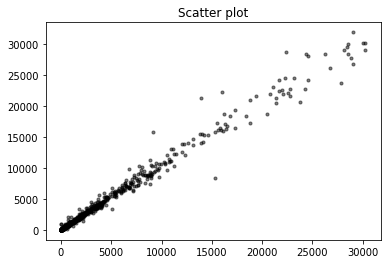

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


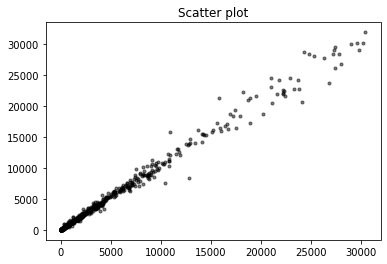

Linear Regression Metrics
Mean Absolute Error: 231.1913979653319
Mean Squared Error: 355810.5781134501
Root Mean Squared Error: 596.4985985846489
R-squared: 0.9858959638891357


In [36]:
x1 = df[['lag_sgna', 'sgna_mkt']]
y1 = df['sgna']
scatter_plot(x = x1['lag_sgna'], y = y1)
scatter_plot(x = x1['sgna_mkt'], y = y1)
x1.fillna(0,inplace=True)
print("Linear Regression Metrics")
rd=LinearReg(x1,y1)
pred=RegPredict(rd,x1,y1)

Distribution of residuals


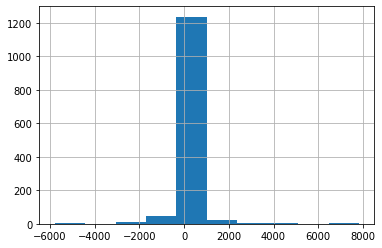

In [37]:
df['R1'] = df['sgna'] - pred
print("Distribution of residuals")
df['R1'].hist()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


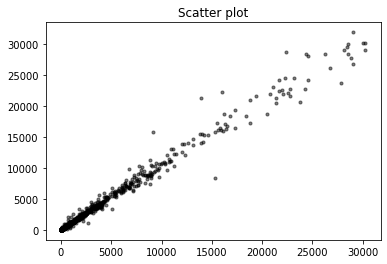

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


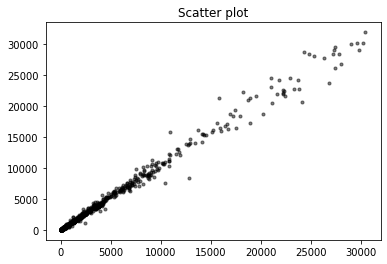

Linear Regression Metrics
Mean Absolute Error: 109.33808907739044
Mean Squared Error: 106210.0079553931
Root Mean Squared Error: 325.89876949045555
R-squared: 0.9922397601181691


In [38]:
x1 = df_imp[['lag_sgna', 'sgna_mkt']]
y1 = df_imp['sgna']
scatter_plot(x = x1['lag_sgna'], y = y1)
scatter_plot(x = x1['sgna_mkt'], y = y1)
x1.fillna(0,inplace=True)
print("Linear Regression Metrics")
rd=LinearReg(x1,y1)
pred=RegPredict(rd,x1,y1)

Distribution of residuals


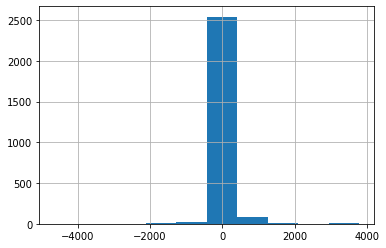

In [39]:
df_imp['R1'] = df_imp['sgna'] - pred
print("Distribution of residuals")
df_imp['R1'].hist()

### Model 1: DV=Gross Profit, IV= SGNA and SQ_SGNA; CONTROL= current assets, age, ppe, emp, operating expenses, liabilities, book value, r1

#### Defining Variables

In [40]:
DV = ['gross_profit']
IV = ['sgna', 'SQ_SGNA']
CV = ['current_assets','age', 'ppe', 'emp', 'operating_expenses','liabilities', 'book_value','R1']

#### Splitting data into Train and Test sets

In [41]:
X = df[IV + CV]
y = df[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [42]:
X_imp = df_imp[IV + CV]
y_imp = df_imp[DV].values.reshape(-1,1)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y_imp, test_size=0.2, random_state=0)

#### Checking Correlation

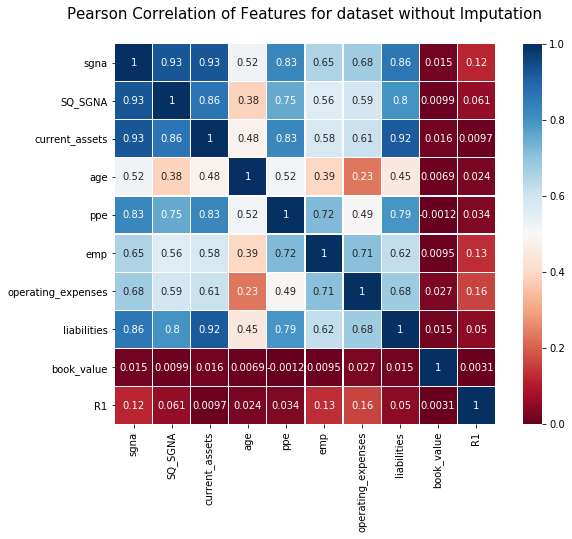

In [43]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10,7))
plt.title('Pearson Correlation of Features for dataset without Imputation', y=1.05, size=15)
sns.heatmap(X.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
# Note that the categorical features have been neglected in the
# correlation matrix.

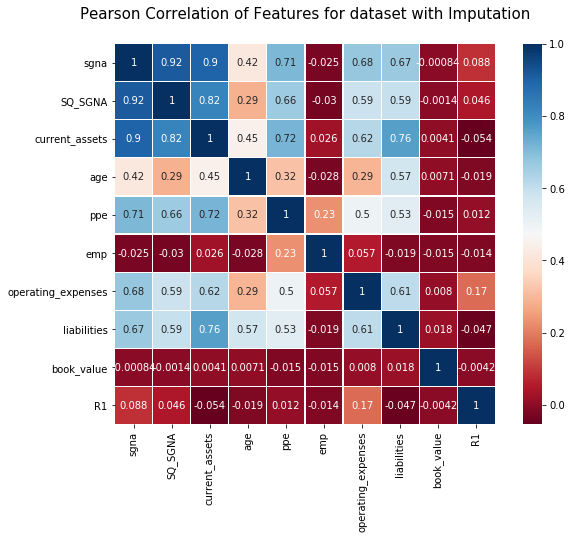

In [44]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10,7))
plt.title('Pearson Correlation of Features for dataset with Imputation', y=1.05, size=15)
sns.heatmap(X_imp.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
# Note that the categorical features have been neglected in the
# correlation matrix.

### Linear Regression

Linear Regression Results - without Imputation
Mean Absolute Error: 621.3147425498869
Mean Squared Error: 4493753.964044287
Root Mean Squared Error: 2119.84762755352
R-squared: 0.946875358390348


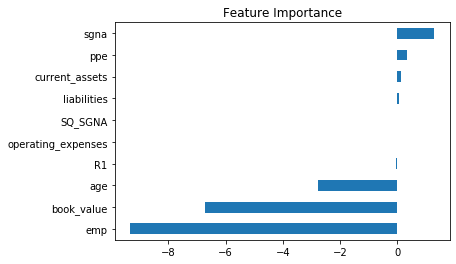

In [45]:
print("Linear Regression Results - without Imputation")
lr=LinearReg(X_train,y_train)
pred=RegPredict(lr,X_test,y_test)

#Plotting Feature Importances 
feature_list = list(X.columns)
plot_feature_imp(lr,index=feature_list)

Linear Regression Results - with Imputation
Mean Absolute Error: 697.3356650721666
Mean Squared Error: 1189484.1370305512
Root Mean Squared Error: 1090.634740428963
R-squared: 0.964031650609924


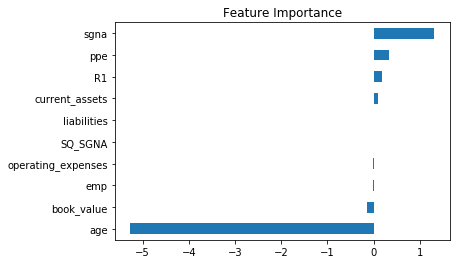

In [46]:
print("Linear Regression Results - with Imputation")
lr=LinearReg(X_train_imp,y_train_imp)
pred=RegPredict(lr,X_test_imp,y_test_imp)

#Plotting Feature Importances 
feature_list = list(X_imp.columns)
plot_feature_imp(lr,index=feature_list)

### Lasso Regression

Lasso Regression Metrics - without Imputation
Mean Absolute Error: 621.1394154964806
Mean Squared Error: 4486449.9601454595
Root Mean Squared Error: 2118.124160701034
R-squared: 0.9469617054829003


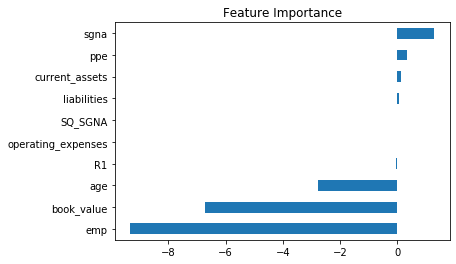

In [47]:
print("Lasso Regression Metrics - without Imputation")
las=LassoReg(X_train,y_train)
pred=RegPredict(las,X_test,y_test)

#Plotting Feature Importances 
feature_list = list(X.columns)
plot_feature_imp_EN(las,index=feature_list)

Lasso Regression Results - with Imputation
Mean Absolute Error: 697.3317521697401
Mean Squared Error: 1189476.8534242348
Root Mean Squared Error: 1090.6314012645312
R-squared: 0.9640318708560699


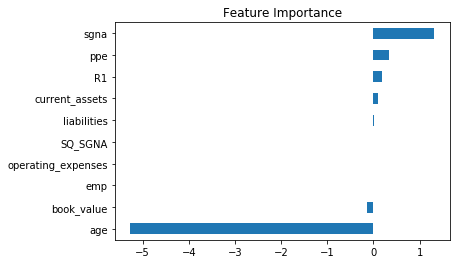

In [48]:
print("Lasso Regression Results - with Imputation")
las=LassoReg(X_train_imp,y_train_imp)
pred=RegPredict(las,X_test_imp,y_test_imp)

#Plotting Feature Importances 
feature_list = list(X_imp.columns)
plot_feature_imp_EN(las,index=feature_list)

### Ridge Regression

Ridge Regression Metrics -- Without Imputation
Mean Absolute Error: 621.3135918649122
Mean Squared Error: 4493706.134676524
Root Mean Squared Error: 2119.8363462014054
R-squared: 0.946875923823623


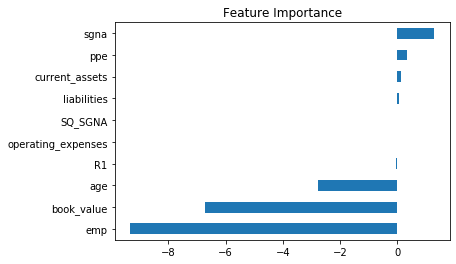

In [49]:
print("Ridge Regression Metrics -- Without Imputation")
rd=RidgeReg(X_train,y_train)
pred=RegPredict(rd,X_test,y_test)

#Plotting Feature Importances 
feature_list = list(X.columns)
plot_feature_imp(rd,index=feature_list)

Ridge Regression Metrics -- With Imputation
Mean Absolute Error: 697.3356545212245
Mean Squared Error: 1189484.1162463455
Root Mean Squared Error: 1090.6347309004723
R-squared: 0.9640316512384095


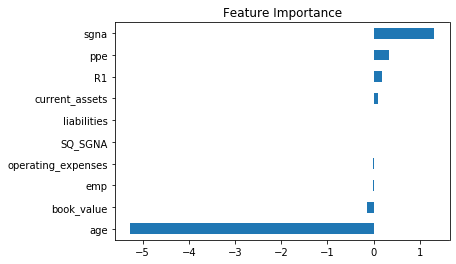

In [50]:
print("Ridge Regression Metrics -- With Imputation")
rd=RidgeReg(X_train_imp,y_train_imp)
pred=RegPredict(rd,X_test_imp,y_test_imp)

#Plotting Feature Importances 
feature_list = list(X_imp.columns)
plot_feature_imp(rd,index=feature_list)

### ElasticNet Regression

ElasticNet Regression Results - without Imputation
Mean Absolute Error: 620.6190661514862
Mean Squared Error: 4464913.69239483
Root Mean Squared Error: 2113.034238339462
R-squared: 0.9472163047589212


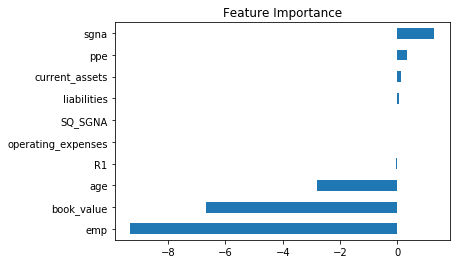

In [51]:
print("ElasticNet Regression Results - without Imputation")
en=ElasticNetReg(X_train,y_train)
pred=RegPredict(en,X_test,y_test)

#Plotting Feature Importances after adding CV individually
feature_list = list(X.columns)
plot_feature_imp_EN(en,index=feature_list)

Lasso Regression Results - with Imputation
Mean Absolute Error: 697.3223875627633
Mean Squared Error: 1189458.202382747
Root Mean Squared Error: 1090.6228506604596
R-squared: 0.9640324348376782


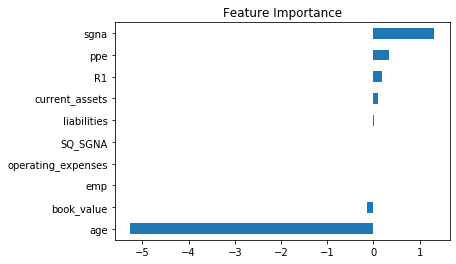

In [52]:
print("Lasso Regression Results - with Imputation")
en=ElasticNetReg(X_train_imp,y_train_imp)
pred=RegPredict(en,X_test_imp,y_test_imp)

#Plotting Feature Importances 
feature_list = list(X_imp.columns)
plot_feature_imp_EN(en,index=feature_list)

### Support Vector Regression

In [53]:
print("Support Vector with RBF Kernel Regression Results - Without Imputation")
svr=SVR_RBF(X_train,y_train)
pred=RegPredict(svr,X_test,y_test)

Support Vector with RBF Kernel Regression Results - Without Imputation
Mean Absolute Error: 4721.015131771856
Mean Squared Error: 101813420.96451224
Root Mean Squared Error: 10090.263671704137
R-squared: -0.20362653208644677


In [54]:
print("Support Vector with RBF Kernel Regression Results - With Imputation")
svr=SVR_RBF(X_train_imp,y_train_imp)
pred=RegPredict(svr,X_test_imp,y_test_imp)

Support Vector with RBF Kernel Regression Results - With Imputation
Mean Absolute Error: 2288.263645074819
Mean Squared Error: 37471906.90736767
Root Mean Squared Error: 6121.430135790792
R-squared: -0.13309845671526288


In [55]:
print("Linear Support Vector Regression Results - Without Imputation")
svr=SVR_Linear(X_train,y_train)
pred=RegPredict(svr,X_test,y_test)

Linear Support Vector Regression Results - Without Imputation
Mean Absolute Error: 1235.9702026078457
Mean Squared Error: 10169060.902454957
Root Mean Squared Error: 3188.896502311569
R-squared: 0.8797825336517866


In [56]:
print("Linear Support Vector Regression Results - with Imputation")
svr=SVR_Linear(X_train_imp,y_train_imp)
pred=RegPredict(svr,X_test_imp,y_test_imp)

Linear Support Vector Regression Results - with Imputation
Mean Absolute Error: 25256.606590469837
Mean Squared Error: 16502510089.753586
Root Mean Squared Error: 128462.09592620535
R-squared: -498.01300088230306


### XGBoost Regression

XGBoost Regression Results - Without Imputation
Mean Absolute Error: 414.3863765763161
Mean Squared Error: 1479196.2013528734
Root Mean Squared Error: 1216.222101983381
R-squared: 0.9825131129349796


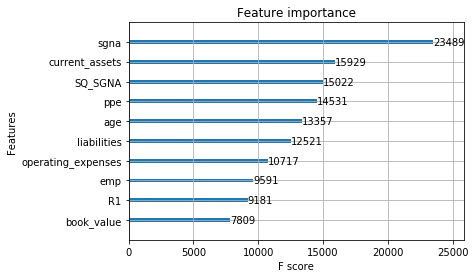

In [57]:
print("XGBoost Regression Results - Without Imputation")
xg=XGBoostReg(X_train,y_train,max_depth=50,objective ='reg:linear',n_estimators=400,learning_rate=0.1)
pred=RegPredict(xg,X_test,y_test)

xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

XGBoost Regression Results - With Imputation
Mean Absolute Error: 298.2356434617561
Mean Squared Error: 516468.3439400934
Root Mean Squared Error: 718.6573202438652
R-squared: 0.984382714098125


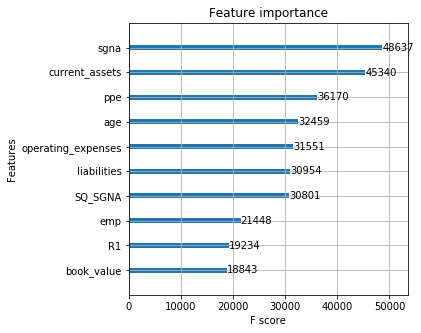

In [58]:
print("XGBoost Regression Results - With Imputation")
xg=XGBoostReg(X_train_imp,y_train_imp,max_depth=50,objective ='reg:linear',n_estimators=400,learning_rate=0.1)
pred=RegPredict(xg,X_test_imp,y_test_imp)

xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### AdaBoosting

In [59]:
print("AdaBoosting Results--Without Imputation")
adb=AdaBoost(X_train,y_train,n_estimators=100,learning_rate=1)
pred=RegPredict(adb,X_test,y_test)

AdaBoosting Results--Without Imputation
Mean Absolute Error: 1566.280405036582
Mean Squared Error: 3703428.1850013956
Root Mean Squared Error: 1924.4293141088335
R-squared: 0.9562184986918557


In [60]:
print("AdaBoosting Results--With Imputation")
adb=AdaBoost(X_train_imp,y_train_imp,n_estimators=100,learning_rate=1)
pred=RegPredict(adb,X_test_imp,y_test_imp)

AdaBoosting Results--With Imputation
Mean Absolute Error: 1454.8078445386889
Mean Squared Error: 2731067.4070913005
Root Mean Squared Error: 1652.5941446983588
R-squared: 0.9174163121238952


### Decision Tree Regression

In [61]:
print("Decision Tree Results --Without Imputation")
dt=DecisionTreeReg(X_train,y_train,max_depth=100)
pred=RegPredict(dt,X_test,y_test)

print("---------------------------------------")
dt=DecisionTreeReg(X_train,y_train,max_depth=200)
pred=RegPredict(dt,X_test,y_test)

Decision Tree Results --Without Imputation
Mean Absolute Error: 670.2857142857143
Mean Squared Error: 4179920.8947368423
Root Mean Squared Error: 2044.4854841100835
R-squared: 0.9505854567770452
---------------------------------------
Mean Absolute Error: 590.218045112782
Mean Squared Error: 3139651.4135338347
Root Mean Squared Error: 1771.9061525751963
R-squared: 0.9628834027279249


In [62]:
print("Decision Tree Results --With Imputation")
dt=DecisionTreeReg(X_train_imp,y_train_imp,max_depth=100)
pred=RegPredict(dt,X_test_imp,y_test_imp)

print("---------------------------------------")
dt=DecisionTreeReg(X_train_imp,y_train_imp,max_depth=200)
pred=RegPredict(dt,X_test_imp,y_test_imp)

Decision Tree Results --With Imputation
Mean Absolute Error: 266.7822534215684
Mean Squared Error: 755107.013288371
Root Mean Squared Error: 868.9689368949681
R-squared: 0.9771666119493989
---------------------------------------
Mean Absolute Error: 242.52711391948657
Mean Squared Error: 487382.11605390935
Root Mean Squared Error: 698.1275786372497
R-squared: 0.9852622412599258


### Orthogonal Matching Pursuit

In [63]:
print("Orthogonal Matching Pursuit Results--Without Imputation")
omp=OrthogonalMatchReg(X_train,y_train)
pred=RegPredict(omp,X_test,y_test)

Orthogonal Matching Pursuit Results--Without Imputation
Mean Absolute Error: 729.8410702279696
Mean Squared Error: 3056676.2319044205
Root Mean Squared Error: 1748.3352744552233
R-squared: 0.9638643257650623


In [64]:
print("Orthogonal Matching Pursuit Results--With Imputation")
omp=OrthogonalMatchReg(X_train_imp,y_train_imp)
pred=RegPredict(omp,X_test_imp,y_test_imp)

Orthogonal Matching Pursuit Results--With Imputation
Mean Absolute Error: 756.0025412131348
Mean Squared Error: 1772361.710104352
Root Mean Squared Error: 1331.3007586959275
R-squared: 0.9464062417900168


### Bayesian Ridge Regression

In [65]:
print("Bayesian Ridge Regression Results--Without Imputation")
br=BayesianRidgeReg(X_train,y_train)
pred=RegPredict(br,X_test,y_test)

Bayesian Ridge Regression Results--Without Imputation
Mean Absolute Error: 567.7091892982667
Mean Squared Error: 2757282.823169318
Root Mean Squared Error: 1660.5067970861542
R-squared: 0.9674037201481562


In [66]:
print("Bayesian Ridge Regression Results--With Imputation")
br=BayesianRidgeReg(X_train_imp,y_train_imp)
pred=RegPredict(br,X_test_imp,y_test_imp)

Bayesian Ridge Regression Results--With Imputation
Mean Absolute Error: 690.5123076572208
Mean Squared Error: 1177768.679493916
Root Mean Squared Error: 1085.2505146250408
R-squared: 0.9643859097856657


### Robust Linear Model Estimation using RANSAC

In [67]:
print("RANSAC Regression Results--Without Imputation")
ran=RansacReg(X_train,y_train)
pred=RegPredict(ran,X_test,y_test)

RANSAC Regression Results--Without Imputation
Mean Absolute Error: 707.0957725428992
Mean Squared Error: 3657135.931931129
Root Mean Squared Error: 1912.3639642942264
R-squared: 0.9567657603740347


In [68]:
print("RANSAC Regression Results--With Imputation")
ran=RansacReg(X_train_imp,y_train_imp)
pred=RegPredict(ran,X_test_imp,y_test_imp)

RANSAC Regression Results--With Imputation
Mean Absolute Error: 4162.277545806341
Mean Squared Error: 462175441.43479455
Root Mean Squared Error: 21498.266009955187
R-squared: -12.975543884543912


### RandomForest Regression

In [69]:
print("RandomForest Regression Results--Without Imputation")
rf=RandomForestReg(X_train,y_train,n_estimators = 1000, random_state = 42)
pred=RegPredict(rf,X_test,y_test)
print("-----------------------------------------")
rf=RandomForestReg(X_train,y_train,n_estimators = 500, random_state = 42)
pred=RegPredict(rf,X_test,y_test)

RandomForest Regression Results--Without Imputation
Mean Absolute Error: 378.46753383458645
Mean Squared Error: 1654747.6000657144
Root Mean Squared Error: 1286.3699312661636
R-squared: 0.9804377645257624
-----------------------------------------
Mean Absolute Error: 378.9690977443609
Mean Squared Error: 1702295.8428852328
Root Mean Squared Error: 1304.7205995481304
R-squared: 0.9798756546774782


In [70]:
print("RandomForest Regression Results--With Imputation")
rf=RandomForestReg(X_train_imp,y_train_imp,n_estimators = 1000, random_state = 42)
pred=RegPredict(rf,X_test_imp,y_test_imp)
print("-----------------------------------------")
rf=RandomForestReg(X_train_imp,y_train_imp,n_estimators = 500, random_state = 42)
pred=RegPredict(rf,X_test_imp,y_test_imp)

RandomForest Regression Results--With Imputation
Mean Absolute Error: 210.4555541967067
Mean Squared Error: 376520.5274945797
Root Mean Squared Error: 613.6126852458151
R-squared: 0.9886145418304869
-----------------------------------------
Mean Absolute Error: 210.98597025689466
Mean Squared Error: 376961.2248276967
Root Mean Squared Error: 613.9716808027034
R-squared: 0.9886012157547879


### Gradient Boosting Regression

In [71]:
print("Gradient Boosting Regression Results--Without Imputation")
gb=GradientBoostReg(X_train,y_train,n_estimators=1000,max_depth=30,learning_rate=1,criterion='mse')
pred=RegPredict(gb,X_test,y_test)
print("------------------------------------------")
gb=GradientBoostReg(X_train,y_train,n_estimators=500,max_depth=50,learning_rate=1,criterion='mse')
pred=RegPredict(gb,X_test,y_test)

Gradient Boosting Regression Results--Without Imputation
Mean Absolute Error: 630.1466165413534
Mean Squared Error: 3619222.7706766916
Root Mean Squared Error: 1902.425496747952
R-squared: 0.957213965398174
------------------------------------------
Mean Absolute Error: 622.6203007518797
Mean Squared Error: 3747733.710526316
Root Mean Squared Error: 1935.9064312425628
R-squared: 0.9556947238738147


In [72]:
print("Gradient Boosting Regression Results--With Imputation")
gb=GradientBoostReg(X_train_imp,y_train_imp,n_estimators=1000,max_depth=30,learning_rate=1,criterion='mse')
pred=RegPredict(gb,X_test_imp,y_test_imp)
print("------------------------------------------")
gb=GradientBoostReg(X_train_imp,y_train_imp,n_estimators=500,max_depth=50,learning_rate=1,criterion='mse')
pred=RegPredict(gb,X_test_imp,y_test_imp)

Gradient Boosting Regression Results--With Imputation
Mean Absolute Error: 273.86094923086785
Mean Squared Error: 732037.7933427165
Root Mean Squared Error: 855.5920718091751
R-squared: 0.9778641931422286
------------------------------------------
Mean Absolute Error: 242.27770982265193
Mean Squared Error: 480982.99644664663
Root Mean Squared Error: 693.5293767726401
R-squared: 0.985455741755357


### Stepwise Regression

In [73]:
result = stepwise_selection(X_train, y_train)
print('Resulting features from Stepwise Selection without Imputation:')
print(result) 

Add  current_assets                 with p-value 0.0
Add  sgna                           with p-value 0.0
Add  ppe                            with p-value 1.39799e-54
Add  liabilities                    with p-value 4.94863e-24
Add  emp                            with p-value 4.92708e-21
Add  age                            with p-value 2.4443e-06
Add  book_value                     with p-value 0.00578585
Resulting features from Stepwise Selection without Imputation:
['current_assets', 'sgna', 'ppe', 'liabilities', 'emp', 'age', 'book_value']


In [74]:
result = stepwise_selection(X_train_imp, y_train_imp)
print('Resulting features from Stepwise Selection with Imputation:')
print(result) 

Add  ppe                            with p-value 0.0
Add  current_assets                 with p-value 0.0
Add  sgna                           with p-value 0.0
Add  age                            with p-value 1.39366e-18
Add  emp                            with p-value 4.68989e-15
Add  SQ_SGNA                        with p-value 7.42456e-08
Resulting features from Stepwise Selection with Imputation:
['ppe', 'current_assets', 'sgna', 'age', 'emp', 'SQ_SGNA']


### Studying the individual effect of Control variables on Model 1 on Data with removed missing values

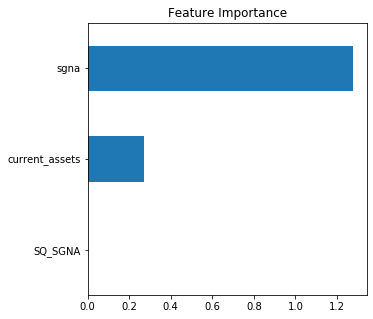

Ridge Regression metrcis for Control variables- current_assets
Mean Absolute Error: 544.5063066852769
Mean Squared Error: 1748828.1023171097
Root Mean Squared Error: 1322.4326456637064
R-squared: 0.9793255556677449
----------------------------------------------------------------------


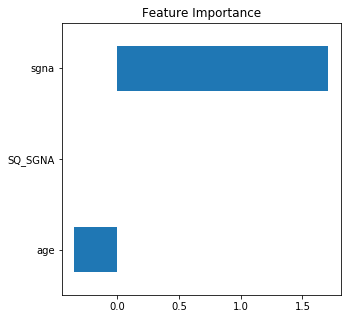

Ridge Regression metrcis for Control variables- age
Mean Absolute Error: 738.1217642506795
Mean Squared Error: 3039758.0335588716
Root Mean Squared Error: 1743.4901873996514
R-squared: 0.9640643307566528
----------------------------------------------------------------------


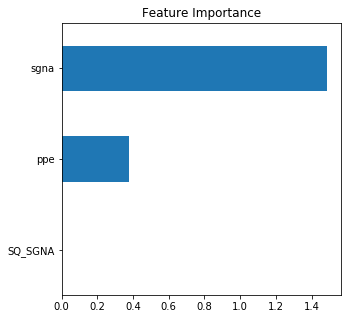

Ridge Regression metrcis for Control variables- ppe
Mean Absolute Error: 564.2858165098816
Mean Squared Error: 2652218.3337165993
Root Mean Squared Error: 1628.5632728624944
R-squared: 0.9686457804373345
----------------------------------------------------------------------


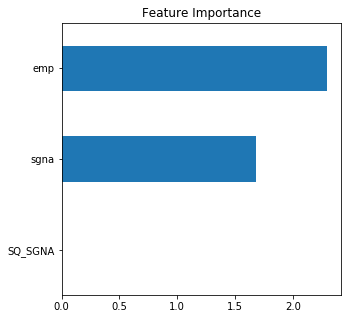

Ridge Regression metrcis for Control variables- emp
Mean Absolute Error: 735.9259518787499
Mean Squared Error: 3092965.316261927
Root Mean Squared Error: 1758.6828356079236
R-squared: 0.9634353203908785
----------------------------------------------------------------------


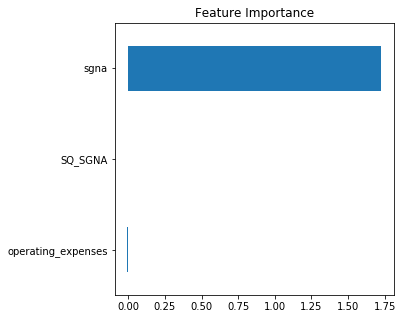

Ridge Regression metrcis for Control variables- operating_expenses
Mean Absolute Error: 733.35454062775
Mean Squared Error: 2994984.029540189
Root Mean Squared Error: 1730.602215860187
R-squared: 0.9645936438734708
----------------------------------------------------------------------


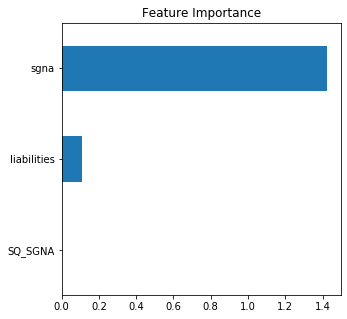

Ridge Regression metrcis for Control variables- liabilities
Mean Absolute Error: 566.888195376408
Mean Squared Error: 2141499.008685875
Root Mean Squared Error: 1463.3861447635327
R-squared: 0.9746834454547051
----------------------------------------------------------------------


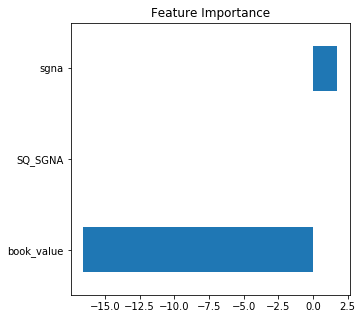

Ridge Regression metrcis for Control variables- book_value
Mean Absolute Error: 1037.548879412382
Mean Squared Error: 20551874.81825883
Root Mean Squared Error: 4533.417564956799
R-squared: 0.7570381038075734
----------------------------------------------------------------------


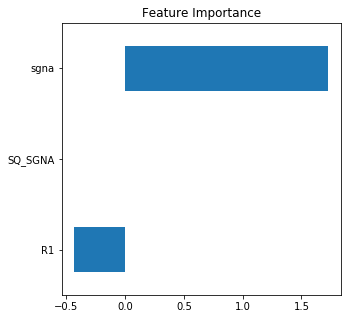

Ridge Regression metrcis for Control variables- R1
Mean Absolute Error: 744.3296237917607
Mean Squared Error: 3018346.369531312
Root Mean Squared Error: 1737.338875847574
R-squared: 0.9643174569818159
----------------------------------------------------------------------


In [75]:
for i in range(len(CV)):
    X = df[IV+[CV[i]]]
    y = df['gross_profit'].values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    ridge=RidgeReg(X_train,y_train)
    
    #Plotting Feature Importances after adding CV individually
    feature_list = list(X.columns)
    plot_feature_imp(ridge,index=feature_list)
    
    print('Ridge Regression metrcis for Control variables-',CV[i])
    pred=RegPredict(ridge,X_test,y_test)
    print("----------------------------------------------------------------------")

### Studying the effect of Control Variables which have positive Feature Importances on model

#### Adding current_assets, ppe, emp, operating_expenses, liabilities

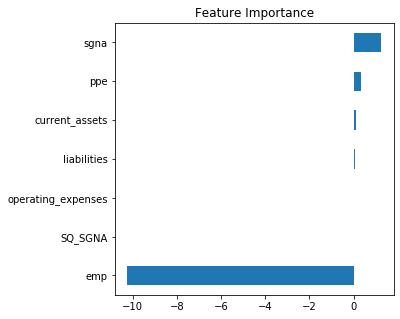

Mean Absolute Error: 480.80695105309053
Mean Squared Error: 1645856.9945405303
Root Mean Squared Error: 1282.9095815919882
R-squared: 0.9805428682399393


In [76]:
X = df[['sgna','SQ_SGNA','current_assets','ppe','emp','operating_expenses','liabilities']]
y = df[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ridge=RidgeReg(X_train,y_train)
#Plotting Feature Importances after adding CV individually
feature_list = list(X.columns)
plot_feature_imp(ridge,index=feature_list)
pred=RegPredict(ridge,X_test,y_test)

### Studying the effect of Control Variables which have negative Feature Importances when added individually

#### Adding book_value,age

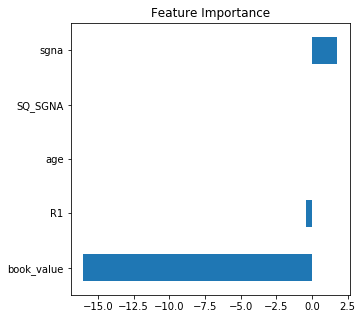

Mean Absolute Error: 1035.7831824830043
Mean Squared Error: 19408230.9144699
Root Mean Squared Error: 4405.477376456483
R-squared: 0.7705581302718553


In [77]:
X = df[['sgna','SQ_SGNA','age','book_value','R1']]
y = df[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ridge=RidgeReg(X_train,y_train)
#Plotting Feature Importances after adding CV individually
feature_list = list(X.columns)
plot_feature_imp(ridge,index=feature_list)
pred=RegPredict(ridge,X_test,y_test)

### Studying the individual effect of Control variables on Model 1 on Data with missing values Imputed

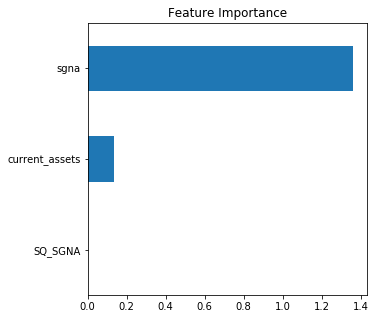

Ridge Regression metrcis for Control variables- current_assets
Mean Absolute Error: 678.9464555696521
Mean Squared Error: 1611099.5130997414
Root Mean Squared Error: 1269.2909489552587
R-squared: 0.9512825868077428
----------------------------------------------------------------------


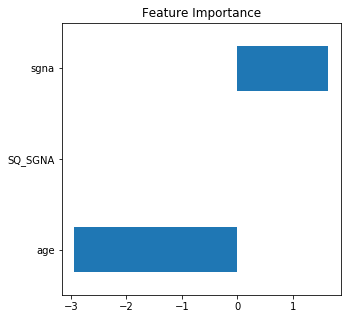

Ridge Regression metrcis for Control variables- age
Mean Absolute Error: 705.6089606492234
Mean Squared Error: 1656779.066800204
Root Mean Squared Error: 1287.1593012522592
R-squared: 0.9499013005035953
----------------------------------------------------------------------


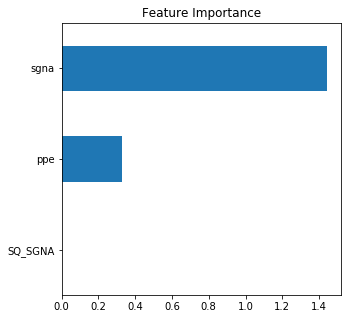

Ridge Regression metrcis for Control variables- ppe
Mean Absolute Error: 669.8335741684649
Mean Squared Error: 1195400.2305032967
Root Mean Squared Error: 1093.3436012998368
R-squared: 0.963852756154397
----------------------------------------------------------------------


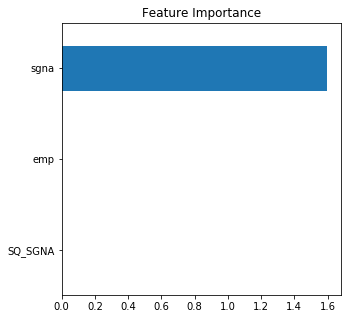

Ridge Regression metrcis for Control variables- emp
Mean Absolute Error: 697.7072244966345
Mean Squared Error: 1650416.353555696
Root Mean Squared Error: 1284.6853130458433
R-squared: 0.950093700121146
----------------------------------------------------------------------


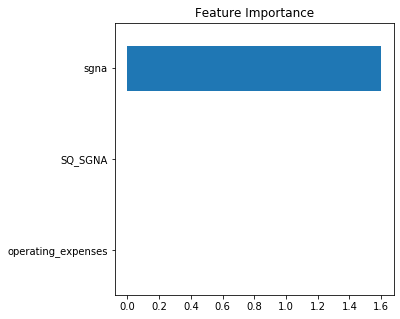

Ridge Regression metrcis for Control variables- operating_expenses
Mean Absolute Error: 697.9775843500003
Mean Squared Error: 1654921.302962553
Root Mean Squared Error: 1286.4374461910509
R-squared: 0.9499574767036106
----------------------------------------------------------------------


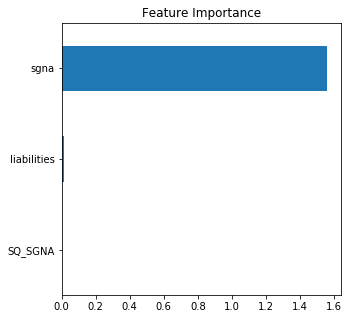

Ridge Regression metrcis for Control variables- liabilities
Mean Absolute Error: 699.7133201106568
Mean Squared Error: 1657588.4534230686
Root Mean Squared Error: 1287.4736709630488
R-squared: 0.949876825775487
----------------------------------------------------------------------


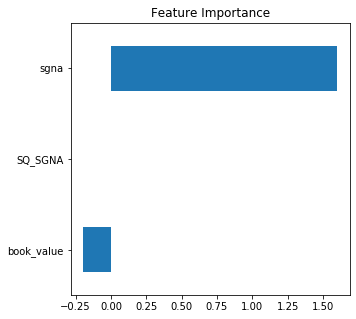

Ridge Regression metrcis for Control variables- book_value
Mean Absolute Error: 696.0272473398547
Mean Squared Error: 1650107.394694434
Root Mean Squared Error: 1284.5650605144272
R-squared: 0.9501030426082991
----------------------------------------------------------------------


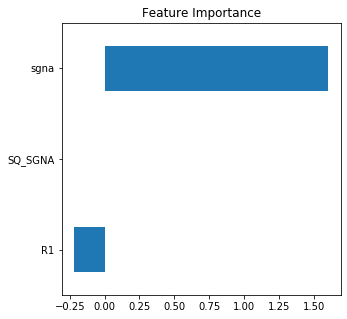

Ridge Regression metrcis for Control variables- R1
Mean Absolute Error: 699.1937068124663
Mean Squared Error: 1671041.6296175504
Root Mean Squared Error: 1292.6877541067488
R-squared: 0.9494700203993538
----------------------------------------------------------------------


In [78]:
for i in range(len(CV)):
    X = df_imp[IV+[CV[i]]]
    y = df_imp['gross_profit'].values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    ridge=RidgeReg(X_train,y_train)
    
    #Plotting Feature Importances after adding CV individually
    feature_list = list(X.columns)
    plot_feature_imp(ridge,index=feature_list)
    
    print('Ridge Regression metrcis for Control variables-',CV[i])
    pred=RegPredict(ridge,X_test,y_test)
    print("----------------------------------------------------------------------")

### Studying the effect of Control Variables which have positive Feature Importances on model
#### Adding current_assets, ppe,liabilities

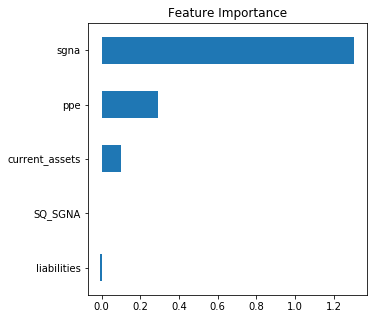

Mean Absolute Error: 664.2489950179227
Mean Squared Error: 1220158.3408337024
Root Mean Squared Error: 1104.6077769207052
R-squared: 0.9631041052603841


In [79]:
X = df_imp[['sgna','SQ_SGNA','current_assets','ppe','liabilities']]
y = df_imp[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ridge=RidgeReg(X_train,y_train)
#Plotting Feature Importances after adding CV individually
feature_list = list(X.columns)
plot_feature_imp(ridge,index=feature_list)
pred=RegPredict(ridge,X_test,y_test)

### Studying the effect of Control Variables which have negative Feature Importances on model
#### Adding age,book_value,R1,emp,operating_expenses

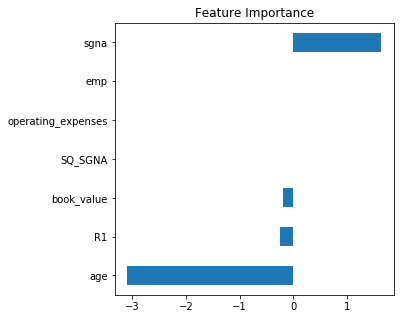

Mean Absolute Error: 708.6968475504252
Mean Squared Error: 1665968.4993309504
Root Mean Squared Error: 1290.724021365896
R-squared: 0.9496234248181006


In [80]:
X = df_imp[['sgna','SQ_SGNA','age','book_value','R1','emp','operating_expenses']]
y = df_imp[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ridge=RidgeReg(X_train,y_train)
#Plotting Feature Importances after adding CV individually
feature_list = list(X.columns)
plot_feature_imp(ridge,index=feature_list)
pred=RegPredict(ridge,X_test,y_test)